In [1]:
import json
import numpy as np
import pandas as pd
import requests as rq
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns

%matplotlib inline

In [2]:
response = rq.get("https://dbrepo.ossdip.at/api/container/1/database/1/table/1/data", verify=False)
df = pd.read_json(json.dumps(response.json()["result"]))
df.head()

/home/mweise/Projects/egi-2022/venv/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dbrepo.ossdip.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


,x_coord,meta_owner,meta_name,meta_location,z_coord,component,unit,y_coord,id,time,value,stationid,meantype
0,14.244676,Amt der Steiermärkischen Landesregierung,Liezen Pyhrnbach,Alte Gasse 12,649.000000,Schwefeldioxid,µg/m³,47.565439,1,-9223372036,0.0,06:177,HMW
1,0.000000,Amt der Burgenländischen Landesregierung,Illmitz im Burgenländischen Messnetz (könnten ...,,0.000000,Schwefeldioxid,µg/m³,0.000000,2,1661072400,0.0,01:0012,HMW
2,15.918900,Amt der Niederösterreichischen Landesregierung,Forsthof am Schöpfl,Forsthof am Schöpfl,581.000000,Schwefeldioxid,µg/m³,48.105100,3,1661092200,0.0,03:0202,HMW
3,0.000000,"Untere Agergasse""","""Vöcklabruck",Amt der Oberösterreichischen Landesregierung,48.000897,Schwefeldioxid,µg/m³,13.667611,4,1661092200,-0.0,04:S407,HMW
4,13.608920,Amt der Oberösterreichischen Landesregierung,Lenzing Hauptstraße,Park Hauptstraße/Stefan Fadinger-Straße,485.000000,Schwefeldioxid,µg/m³,47.973860,5,1661092200,0.0,04:S432,HMW


In [16]:
df_corr = df.corr()[['value']].sort_values('value')
print(df_corr)

            value
time     0.009416
x_coord  0.015221
id       0.017482
y_coord  0.023788
z_coord  0.195958
value    1.000000


,value
time,0.009416
x_coord,0.015221
id,0.017482
y_coord,0.023788
z_coord,0.195958


In [4]:
df_corr_fil = df_corr[abs(df_corr['value']) > 0.55]
print(df_corr_fil)

       value
value    1.0


In [5]:
unwanted = ['meta_owner', 'meta_name', 'meta_location', 'value']
predictors = df_corr.index.tolist()
predictors = [i for i in predictors if i not in unwanted]
df2 = df[['value'] + predictors]
df2 = df2.fillna(0)
df2 = df2[(df2["time"] > 1640991600)] # 01.01.2022 00:00:00 # todo filter by component = OZON

In [6]:
df2.head()

,value,time,x_coord,id,y_coord,z_coord
1,0.0,1661072400,0.00000,2,0.000000,0.000000
2,0.0,1661092200,15.91890,3,48.105100,581.000000
3,-0.0,1661092200,0.00000,4,13.667611,48.000897
4,0.0,1661092200,13.60892,5,47.973860,485.000000
5,0.0,1661092200,0.00000,6,15.086667,47.063330


In [7]:
# separate the predictor variables (X) from the outcome variable y
X = df2[predictors]
y = df2['value']

# Add a constant to the predictor variable set to represent the Bo intercept
# X = sm.add_constant(X)
X.iloc[:5, :5]

,time,x_coord,id,y_coord,z_coord
1,1661072400,0.00000,2,0.000000,0.000000
2,1661092200,15.91890,3,48.105100,581.000000
3,1661092200,0.00000,4,13.667611,48.000897
4,1661092200,13.60892,5,47.973860,485.000000
5,1661092200,0.00000,6,15.086667,47.063330


In [8]:
alpha = 0.01

def stepwise_selection(X, y,
                       initial_list=predictors,
                       threshold_out=alpha,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

Drop y_coord                        with p-value 0.16705
resulting features:
['time', 'x_coord', 'id', 'z_coord']


In [9]:
X = X[result]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1261.
Date:                Wed, 24 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:52:26   Log-Likelihood:            -3.8164e+05
No. Observations:               83180   AIC:                         7.633e+05
Df Residuals:                   83176   BIC:                         7.633e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time        7.854e-09   1.04e-10     75.688      0.000    7.65e-09    8.06e-09
x_coord       -0.2466      0.012    -19.952      0.000      -0.271      -0.222
id          2.104e-06   3.74e-06      0.562      0.574   -5.23e-06    9.44e-06
z_coord        0.0137      0.000     61.226      0.000       0.013       0.014
==============================================================================
Omnibus:                    31536.760   Durbin-Watson:                   0.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103124.519
Skew:                           1.991   Prob(JB):                         0.00
Kurtosis:                       6.728   Cond. No.                     2.49e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12)

In [11]:
# instantiate the regressor class
regressor = LinearRegression()

# fit the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluate the prediction accuracy of the model
print('The Explained Variance: %.2f' % regressor.score(X_test, y_test))
print('The Mean Absolute Error: %.2f µg/m^3' % mean_absolute_error(
    y_test, prediction))
print('The Median Absolute Error: %.2f µg/m^3' %
      median_absolute_error(y_test, prediction))

The Explained Variance: 0.04
The Mean Absolute Error: 16.14 µg/m^3
The Median Absolute Error: 11.10 µg/m^3


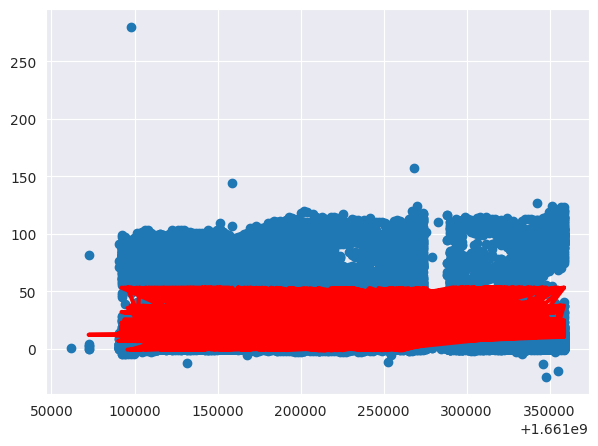

In [12]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.scatter(X_train["time"], y_train)
plt.plot(X_test["time"], prediction, color="red", linewidth=3)

<AxesSubplot:xlabel='time'>

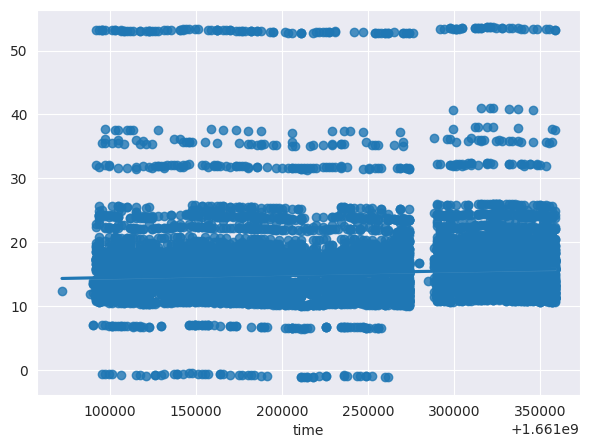

In [13]:
sns.regplot(x=X_test["time"], y=prediction)

In [13]:
unwanted = ['mintempm', 'maxtempm', 'meantempm']
predictors = df_corr_fil.index.tolist()
predictors = [i for i in predictors if i not in unwanted]
df2 = df[['meantempm'] + predictors]

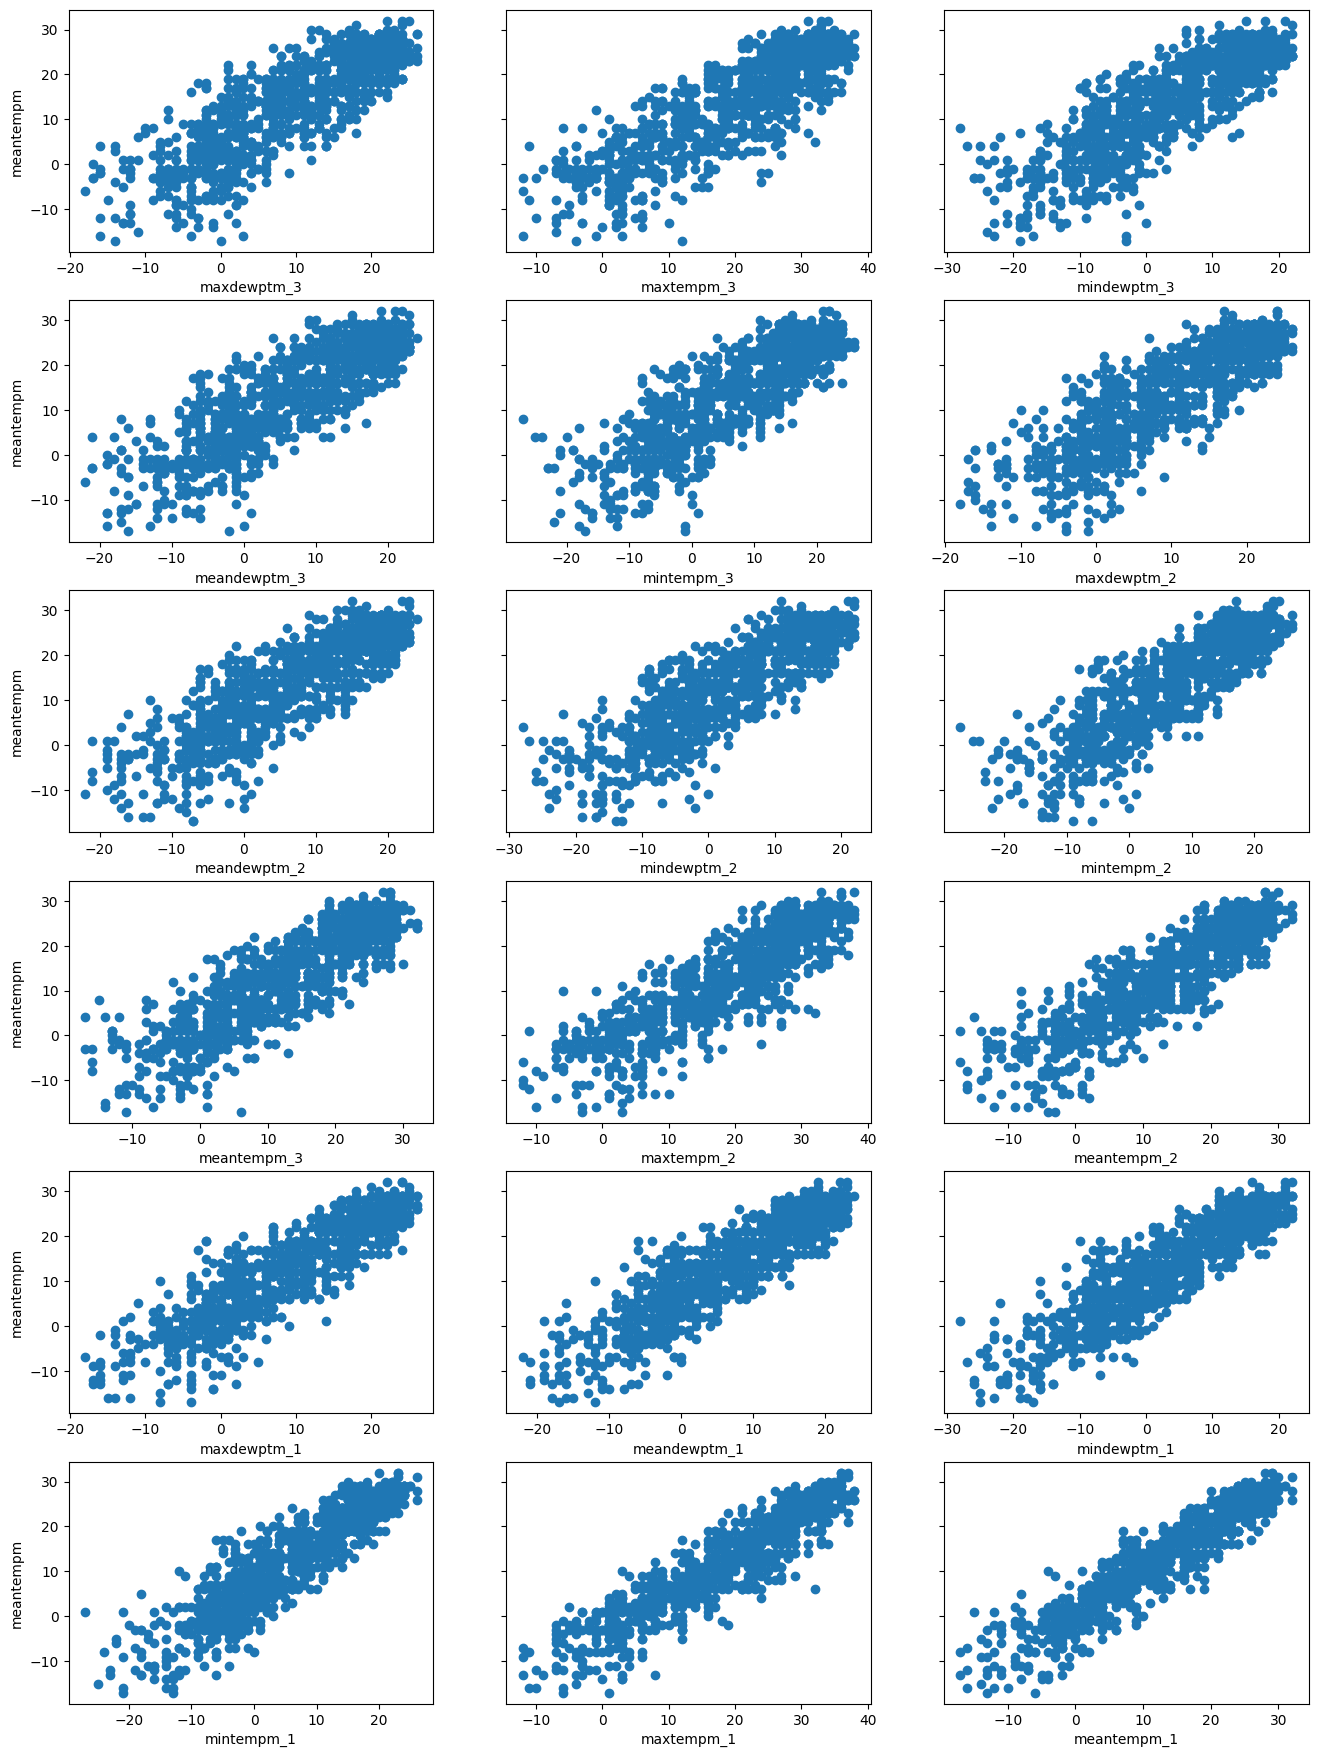

In [50]:
# manually set the parameters of the figure to an appropriate size
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that
# the y axes should be shared
fig, axes = plt.subplots(nrows=6, ncols=3, sharey=True)

# Since it would be nice to loop through the features in to build this plot
# let us rearrange our data into a 2D array of 6 rows and 3 columns
arr = np.array(predictors).reshape(6, 3)

# use enumerate to loop over the arr 2D array of rows and columns
# and create scatter plots of each meantempm vs each feature
for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['meantempm'])
        if col ==0:
            axes[row, col].set(xlabel=feature, ylabel='meantempm')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()


In [51]:
# separate the predictor variables (X) from the outcome variable y
X = df2[predictors]
y = df2['meantempm']

# Add a constant to the predictor variable set to represent the Bo intercept
# X = sm.add_constant(X)
X.iloc[:5, :5]

,maxdewptm_3,maxtempm_3,mindewptm_3,meandewptm_3,mintempm_3
date,,,,,
2015-01-04,-6.0,2.0,-18.0,-12.0,-13.0
2015-01-05,-6.0,1.0,-13.0,-9.0,-12.0
2015-01-06,-4.0,3.0,-16.0,-11.0,-13.0
2015-01-07,-16.0,-12.0,-23.0,-19.0,-18.0
2015-01-08,-8.0,-3.0,-17.0,-14.0,-14.0


In [52]:
alpha = 0.01

def stepwise_selection(X, y,
                       initial_list=predictors,
                       threshold_out=alpha,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

Drop meandewptm_3                   with p-value 0.965003
Drop meandewptm_2                   with p-value 0.929895
Drop mindewptm_2                    with p-value 0.78149
Drop meandewptm_1                   with p-value 0.750582
Drop meantempm_3                    with p-value 0.714618
Drop meantempm_1                    with p-value 0.713733
Drop maxdewptm_2                    with p-value 0.679104
Drop mindewptm_3                    with p-value 0.47157
Drop maxtempm_3                     with p-value 0.274823
Drop meantempm_2                    with p-value 0.236971
Drop maxtempm_2                     with p-value 0.27498
Drop mintempm_3                     with p-value 0.0292387
Drop mintempm_2                     with p-value 0.0459828
Drop mintempm_1                     with p-value 0.0344203
resulting features:
['maxdewptm_3', 'maxdewptm_1', 'mindewptm_1', 'maxtempm_1']


In [53]:
X = X[result]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              meantempm   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              5358.
Date:                Wed, 24 Aug 2022   Prob (F-statistic):                        0.00
Time:                        12:57:28   Log-Likelihood:                         -2691.7
No. Observations:                 997   AIC:                                      5391.
Df Residuals:                     993   BIC:                                      5411.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
maxdewptm_3     0.1733      0.021      8.157      0.000       0.132       0.215
maxdewptm_1    -0.1630      0.043     -3.768      0.000      -0.248      -0.078
mindewptm_1     0.3348      0.027     12.349      0.000       0.282       0.388
maxtempm_1      0.6089      0.019     32.800      0.000       0.572       0.645
==============================================================================
Omnibus:                       12.622   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.669
Skew:                          -0.193   Prob(JB):                     0.000653
Kurtosis:                       3.451   Cond. No.                         13.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12)

In [55]:
# instantiate the regressor class
regressor = LinearRegression()

# fit the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluate the prediction accuracy of the model
print('The Explained Variance: %.2f' % regressor.score(X_test, y_test))
print('The Mean Absolute Error: %.2f degrees celcius' % mean_absolute_error(
    y_test, prediction))
print('The Median Absolute Error: %.2f degrees celcius' %
      median_absolute_error(y_test, prediction))

The Explained Variance: 0.90
The Mean Absolute Error: 2.68 degrees celcius
The Median Absolute Error: 2.04 degrees celcius


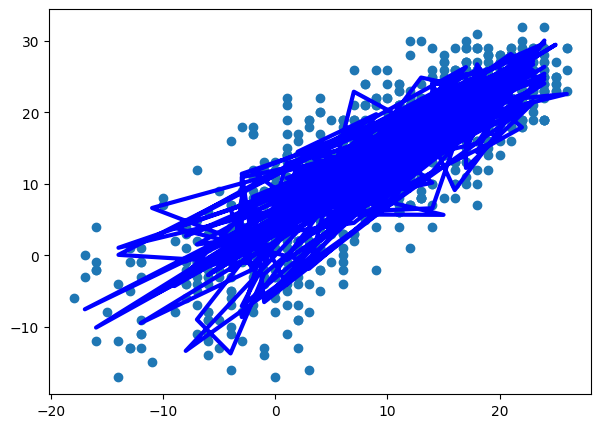

In [77]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.scatter(X_train["maxdewptm_3"], y_train)
plt.plot(X_test["maxdewptm_3"], prediction, color="blue", linewidth=3)

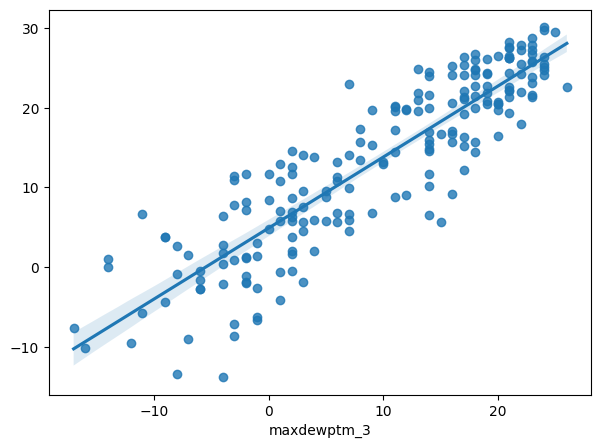

In [78]:
sns.regplot(x=X_test["maxdewptm_3"], y=prediction);